# Finetune Stable Diffusion and generate images with Intel Gaudi

<a id="try-anyscale-quickstart-intel_gaudi-sd" href="https://www.anyscale.com/ray-on-anyscale?utm_source=ray_docs&utm_medium=docs&utm_campaign=intel_gaudi-sd">
    <img src="../../../_static/img/run-on-anyscale.svg" alt="try-anyscale-quickstart">
</a>
<br></br>

In this tutorial, we will go through how to finetune a stable diffusion model and generate images with Intel Gaudi(HPU). Moreover, we will show how to adapt an existing HPU example to use Ray. Once you learned how to make the adaption, you can easily access more models and optimizations that has been developed for HPU by "Ray-ifying" examples from [optimum-habana/examples](https://github.com/huggingface/optimum-habana/tree/main/examples) and [Model References](https://github.com/HabanaAI/Model-References)!

Now, let's see how we can "Ray-ify" this [stable diffusion example](https://github.com/huggingface/optimum-habana/tree/main/examples/stable-diffusion)

## Configuration
A node with Gaudi/Gaudi2 installed is required to run this example. Both Gaudi and Gaudi2 have 8 HPUs.

We recommend using a prebuilt container to run these examples. To run a container, you need Docker. See [Install Docker Engine](https://docs.docker.com/engine/install/) for installation instructions.

Next, follow [Run Using Containers](https://docs.habana.ai/en/latest/Installation_Guide/Bare_Metal_Fresh_OS.html?highlight=installer#run-using-containers) to install the Gaudi drivers and container runtime.

Then, start the Gaudi container:
```bash
docker pull vault.habana.ai/gaudi-docker/1.20.0/ubuntu22.04/habanalabs/pytorch-installer-2.6.0:latest
docker run -it --runtime=habana -e HABANA_VISIBLE_DEVICES=all -e OMPI_MCA_btl_vader_single_copy_mechanism=none --cap-add=sys_nice --net=host --ipc=host vault.habana.ai/gaudi-docker/1.20.0/ubuntu22.04/habanalabs/pytorch-installer-2.6.0:latest
```

Inside the container, clone [Optimum-Habana](https://github.com/huggingface/optimum-habana/) and install the dependencies:
```bash
git clone https://github.com/huggingface/optimum-habana.git
pip install ray[train,serve] optimum-habana
cd optimum-habana/
pip install -r examples/stable-diffusion/requirements.txt
pip install -r examples/stable-diffusion/training/requirements.txt
```

## Fine-tuning with Textual Inversion
First, let's start with fine-tuning. Check `examples/stable-diffusion/training/textual_inversion.py` which fine-tunes a Stable Diffusion model on HPU. You can follow [this document](https://github.com/huggingface/optimum-habana/blob/main/examples/stable-diffusion/training/README.md#textual-inversion) and try it once without using Ray.

In order to run this script on Ray, we need to make some changes. But don't worry, it's actually pretty simple. Basically, we just need to identify the main training loop, and run it in TorchTrainer.

First, check this block at the end of the file:
```python
if __name__ == "__main__":
    main()
```

Originally, this script will be started by MPI if multiple workers are used. But with Ray, we should setup TorchTrainer and supply a main function, which is `main()` in this example.

Therefore, it becomes straight-forward to make these changes:
```python
if __name__ == "__main__":
    import ray
    from ray import train
    from ray.train import ScalingConfig, Checkpoint, CheckpointConfig, RunConfig
    from ray.train.torch import TorchTrainer, TorchConfig

    ray.init()

    # Configure computation resources
    # In ScalingConfig, require an HPU for each worker
    scaling_config = ScalingConfig(num_workers=1, resources_per_worker={"CPU": 1, "HPU": 1})
    # Set backend to hccl in TorchConfig
    torch_config = TorchConfig(backend = "hccl")
    # Initialize a Ray TorchTrainer
    trainer = TorchTrainer(
        train_loop_per_worker=main,
        torch_config=torch_config,
        scaling_config=scaling_config,
    )

    result = trainer.fit()
```

Before we try to run, we need to inspect the `main` function to see if it can work in such way. As we skim through the function, it's clear that it does not take any input parameters, but it calls `parse_args` to get all configurations. Originally, these configurations are set in command line by MPI. But because we switch to Ray to start the workers, command line arguments are no longer accessible. Therefore, `parse_args` should be called in the main program and passed to `main` function.

Apart from this, no other changes are necessary. By inserting the following code, you can now run the script on Ray.

In [ ]:
# Replace lines below:
# def main():
#     args = parse_args()
# with these lines:
def main(config):
    args = config["args"]

In [ ]:
# Replace lines below:
# if __name__ == "__main__":
#     main()
# with these lines:
if __name__ == "__main__":
    import ray
    from ray import train
    from ray.train import ScalingConfig, Checkpoint, CheckpointConfig, RunConfig
    from ray.train.torch import TorchTrainer, TorchConfig

    ray.init()

    # Configure computation resources
    # In ScalingConfig, require an HPU for each worker
    scaling_config = ScalingConfig(num_workers=1, resources_per_worker={"CPU": 1, "HPU": 1})
    # Set backend to hccl in TorchConfig
    torch_config = TorchConfig(backend = "hccl")
    # Initialize a Ray TorchTrainer
    trainer = TorchTrainer(
        train_loop_per_worker=main,
		train_loop_config={"args": parse_args()},
        torch_config=torch_config,
        scaling_config=scaling_config,
    )

    result = trainer.fit()

One last thing: remember to use absolute path in the command line arguments. The reason is similar to why we move `parse_args` out, Ray's workers do not share the current working directory. Now, you can run the fine-tuning of Stable Diffusion on Ray!
An example command:
```bash
python /root/optimum-habana/examples/stable-diffusion/training/textual_inversion.py \
  --pretrained_model_name_or_path runwayml/stable-diffusion-v1-5 \
  --train_data_dir "/root/cat" \
  --learnable_property object \
  --placeholder_token "<cat-toy>" \
  --initializer_token toy \
  --resolution 512 \
  --train_batch_size 4 \
  --max_train_steps 3000 \
  --learning_rate 5.0e-04 \
  --scale_lr \
  --lr_scheduler constant \
  --lr_warmup_steps 0 \
  --output_dir /tmp/textual_inversion_cat \
  --save_as_full_pipeline \
  --gaudi_config_name Habana/stable-diffusion \
  --throughput_warmup_steps 3
```

The output of the example command:
``` text
[WARNING|utils.py:212] 2025-03-03 04:58:56,864 >> optimum-habana v1.15.0 has been validated for SynapseAI v1.19.0 but habana-frameworks v1.20.0.543 was found, this could lead to undefined behavior!
2025-03-03 04:59:03,264 INFO worker.py:1841 -- Started a local Ray instance.
/usr/local/lib/python3.10/dist-packages/ray/tune/impl/tuner_internal.py:125: RayDeprecationWarning: The `RunConfig` class should be imported from `ray.tune` when passing it to the Tuner. Please update your imports. See this issue for more context and migr
ation options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
  _log_deprecation_warning(
(TrainTrainable pid=107296) [WARNING|utils.py:212] 2025-03-03 04:59:12,099 >> optimum-habana v1.15.0 has been validated for SynapseAI v1.19.0 but habana-frameworks v1.20.0.543 was found, this could lead to undefined behavior!
(RayTrainWorker pid=107684) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=107296) Started distributed worker processes: 
(TorchTrainer pid=107296) - (node_id=12919215a37e8438e19d84528dbde19a70ae3b0cc3a7aeaedb1af745, ip=100.83.111.228, pid=107684) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=107684) [WARNING|utils.py:212] 2025-03-03 04:59:21,829 >> optimum-habana v1.15.0 has been validated for SynapseAI v1.19.0 but habana-frameworks v1.20.0.543 was found, this could lead to undefined behavior!
(RayTrainWorker pid=107684) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to for
ce a new download, use `force_download=True`.
(RayTrainWorker pid=107684)   warnings.warn(
(RayTrainWorker pid=107684) 03/03/2025 04:59:25 - INFO - __main__ - Distributed environment: MULTI_HPU  Backend: hccl
(RayTrainWorker pid=107684) Num processes: 1
(RayTrainWorker pid=107684) Process index: 0
(RayTrainWorker pid=107684) Local process index: 0
(RayTrainWorker pid=107684) Device: hpu
(RayTrainWorker pid=107684) 
(RayTrainWorker pid=107684) Mixed precision type: bf16
(RayTrainWorker pid=107684) 
(RayTrainWorker pid=107684) {'prediction_type', 'thresholding', 'rescale_betas_zero_snr', 'timestep_spacing', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio'} was not found in config. Values will be initialized to default valu
es.
(RayTrainWorker pid=107684) ============================= HABANA PT BRIDGE CONFIGURATION =========================== 
(RayTrainWorker pid=107684)  PT_HPU_LAZY_MODE = 1
(RayTrainWorker pid=107684)  PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024
(RayTrainWorker pid=107684)  PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
(RayTrainWorker pid=107684)  PT_HPU_LAZY_ACC_PAR_MODE = 1
(RayTrainWorker pid=107684)  PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
(RayTrainWorker pid=107684)  PT_HPU_EAGER_PIPELINE_ENABLE = 1
(RayTrainWorker pid=107684)  PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
(RayTrainWorker pid=107684)  PT_HPU_ENABLE_LAZY_COLLECTIVES = 0
(RayTrainWorker pid=107684) ---------------------------: System Configuration :---------------------------
(RayTrainWorker pid=107684) Num CPU Cores : 160
(RayTrainWorker pid=107684) CPU RAM       : 1056374420 KB
(RayTrainWorker pid=107684) ------------------------------------------------------------------------------
(RayTrainWorker pid=107684) {'shift_factor', 'latents_mean', 'scaling_factor', 'mid_block_add_attention', 'use_post_quant_conv', 'latents_std', 'use_quant_conv', 'force_upcast'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=107684) {'attention_type', 'reverse_transformer_layers_per_block', 'conv_out_kernel', 'dropout', 'addition_time_embed_dim', 'mid_block_type', 'timestep_post_act', 'time_cond_proj_dim', 'encoder_hid_dim_type', 'time_embedding_typ
e', 'resnet_time_scale_shift', 'encoder_hid_dim', 'dual_cross_attention', 'mid_block_only_cross_attention', 'num_attention_heads', 'num_class_embeds', 'resnet_out_scale_factor', 'conv_in_kernel', 'use_linear_projection', 'class_embed_type', 'addition_embe
d_type', 'addition_embed_type_num_heads', 'class_embeddings_concat', 'projection_class_embeddings_input_dim', 'resnet_skip_time_act', 'transformer_layers_per_block', 'upcast_attention', 'time_embedding_dim', 'cross_attention_norm', 'only_cross_attention',
 'time_embedding_act_fn'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=107684) 03/03/2025 04:59:31 - INFO - __main__ - ***** Running training *****
(RayTrainWorker pid=107684) 03/03/2025 04:59:31 - INFO - __main__ -   Num examples = 600
(RayTrainWorker pid=107684) 03/03/2025 04:59:31 - INFO - __main__ -   Num Epochs = 20
(RayTrainWorker pid=107684) 03/03/2025 04:59:31 - INFO - __main__ -   Instantaneous batch size per device = 4
(RayTrainWorker pid=107684) 03/03/2025 04:59:31 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 4
(RayTrainWorker pid=107684) 03/03/2025 04:59:31 - INFO - __main__ -   Gradient Accumulation steps = 1
(RayTrainWorker pid=107684) 03/03/2025 04:59:31 - INFO - __main__ -   Total optimization steps = 3000

...

Steps:   0%|          | 0/3000 [00:00<?, ?it/s]
Steps:   0%|          | 1/3000 [00:41<34:47:32, 41.76s/it, loss=0.146, lr=0.002]
Steps:   0%|          | 2/3000 [01:10<28:13:25, 33.89s/it, loss=0.146, lr=0.002]
Steps:   0%|          | 3/3000 [01:30<22:57:31, 27.58s/it, loss=0.0955, lr=0.002]
Steps:   0%|          | 4/3000 [01:30<14:00:18, 16.83s/it, loss=nan, lr=0.002]   
Steps:   0%|          | 5/3000 [01:30<9:03:04, 10.88s/it, loss=nan, lr=0.002]
Steps:   0%|          | 6/3000 [01:31<6:04:12,  7.30s/it, loss=nan, lr=0.002]
Steps:   0%|          | 7/3000 [01:31<4:10:49,  5.03s/it, loss=nan, lr=0.002]
Steps:   0%|          | 8/3000 [01:31<2:56:20,  3.54s/it, loss=nan, lr=0.002]
Steps:   0%|          | 9/3000 [01:32<2:06:37,  2.54s/it, loss=nan, lr=0.002]
Steps:   0%|          | 10/3000 [01:32<1:33:00,  1.87s/it, loss=nan, lr=0.002]
Steps:   0%|          | 11/3000 [01:32<1:09:50,  1.40s/it, loss=nan, lr=0.002]
Steps:   0%|          | 12/3000 [01:33<53:52,  1.08s/it, loss=nan, lr=0.002]
Steps:   0%|          | 13/3000 [01:33<42:48,  1.16it/s, loss=nan, lr=0.002]
Steps:   0%|          | 14/3000 [01:34<34:50,  1.43it/s, loss=nan, lr=0.002]
Steps:   0%|          | 15/3000 [01:34<29:16,  1.70it/s, loss=nan, lr=0.002]

...

Steps:  99%|█████████▉| 2977/3000 [19:01<00:07,  2.95it/s, loss=nan, lr=0.002]
Steps:  99%|█████████▉| 2978/3000 [19:01<00:07,  2.92it/s, loss=nan, lr=0.002]
Steps:  99%|█████████▉| 2979/3000 [19:01<00:07,  2.90it/s, loss=nan, lr=0.002]
Steps:  99%|█████████▉| 2980/3000 [19:02<00:06,  2.90it/s, loss=nan, lr=0.002]
Steps:  99%|█████████▉| 2981/3000 [19:02<00:06,  2.92it/s, loss=nan, lr=0.002]
Steps:  99%|█████████▉| 2982/3000 [19:02<00:06,  2.95it/s, loss=nan, lr=0.002]
Steps:  99%|█████████▉| 2983/3000 [19:03<00:05,  2.94it/s, loss=nan, lr=0.002]
Steps:  99%|█████████▉| 2984/3000 [19:03<00:05,  2.94it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2985/3000 [19:03<00:05,  2.95it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2986/3000 [19:04<00:04,  2.96it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2987/3000 [19:04<00:04,  2.94it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2988/3000 [19:04<00:04,  2.94it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2989/3000 [19:05<00:03,  2.93it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2990/3000 [19:05<00:03,  2.91it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2991/3000 [19:06<00:03,  2.88it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2992/3000 [19:06<00:02,  2.91it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2993/3000 [19:06<00:02,  2.93it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2994/3000 [19:07<00:02,  2.92it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2995/3000 [19:07<00:01,  2.92it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2996/3000 [19:07<00:01,  2.92it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2997/3000 [19:08<00:01,  2.91it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2998/3000 [19:08<00:00,  2.95it/s, loss=nan, lr=0.002]
Steps: 100%|█████████▉| 2999/3000 [19:08<00:00,  2.95it/s, loss=nan, lr=0.002]
Steps: 100%|██████████| 3000/3000 [19:08<00:00,  3.26it/s, loss=nan, lr=0.002]03/03/2025 05:18:40 - INFO - __main__ - Saving embeddings

...

(RayTrainWorker pid=107684) 03/03/2025 05:18:40 - INFO - accelerate.accelerator - Saving current state to /tmp/textual_inversion_cat/checkpoint-3000
(RayTrainWorker pid=107684) 03/03/2025 05:18:40 - INFO - accelerate.checkpointing - Model weights saved in /tmp/textual_inversion_cat/checkpoint-3000/model.safetensors
(RayTrainWorker pid=107684) 03/03/2025 05:18:41 - INFO - accelerate.checkpointing - Optimizer state saved in /tmp/textual_inversion_cat/checkpoint-3000/optimizer.bin
(RayTrainWorker pid=107684) 03/03/2025 05:18:41 - INFO - accelerate.checkpointing - Scheduler state saved in /tmp/textual_inversion_cat/checkpoint-3000/scheduler.bin
(RayTrainWorker pid=107684) 03/03/2025 05:18:41 - INFO - accelerate.checkpointing - Sampler state for dataloader 0 saved in /tmp/textual_inversion_cat/checkpoint-3000/sampler.bin
(RayTrainWorker pid=107684) 03/03/2025 05:18:41 - INFO - accelerate.checkpointing - Random states saved in /tmp/textual_inversion_cat/checkpoint-3000/random_states_0.pkl
(RayTrainWorker pid=107684) 03/03/2025 05:18:41 - INFO - __main__ - Saved state to /tmp/textual_inversion_cat/checkpoint-3000
Steps: 100%|██████████| 3000/3000 [19:09<00:00,  3.26it/s, loss=nan, lr=0.002]03/03/2025 05:18:41 - INFO - __main__ - Throughput = 11.313977242831225 samples/s
(RayTrainWorker pid=107684) 03/03/2025 05:18:41 - INFO - __main__ - Train runtime = 1059.5743426650297 seconds
(RayTrainWorker pid=107684) 
(RayTrainWorker pid=107684)      | 0/4 [00:00<?, ?it/s]
Fetching 4 files: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]
(RayTrainWorker pid=107684) {'bf16_full_eval', 'use_habana', 'requires_safety_checker', 'image_encoder', 'sdp_on_bf16', 'use_hpu_graphs', 'gaudi_config'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=107684)                                          Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
(RayTrainWorker pid=107684) Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of runwayml/stable-diffusion-v1-5.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]
(RayTrainWorker pid=107684) [INFO|pipeline_utils.py:210] 2025-03-03 05:18:48,238 >> Running on CPU.
(RayTrainWorker pid=107684) Configuration saved in /tmp/textual_inversion_cat/vae/config.json
(RayTrainWorker pid=107684) Model weights saved in /tmp/textual_inversion_cat/vae/diffusion_pytorch_model.safetensors
(RayTrainWorker pid=107684) Configuration saved in /tmp/textual_inversion_cat/unet/config.json
(RayTrainWorker pid=107684) Model weights saved in /tmp/textual_inversion_cat/unet/diffusion_pytorch_model.safetensors
(RayTrainWorker pid=107684) Configuration saved in /tmp/textual_inversion_cat/scheduler/scheduler_config.json
(RayTrainWorker pid=107684) Configuration saved in /tmp/textual_inversion_cat/model_index.json
(RayTrainWorker pid=107684) 03/03/2025 05:18:56 - INFO - __main__ - Saving embeddings
Steps: 100%|██████████| 3000/3000 [19:24<00:00,  2.58it/s, loss=nan, lr=0.002]
2025-03-03 05:18:57,227 INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/TorchTrainer_2025-03-03_04-59-05' in 0.0021s.

View detailed results here: /root/ray_results/TorchTrainer_2025-03-03_04-59-05
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-03-03_04-59-01_486557_97751/artifacts/2025-03-03_04-59-05/TorchTrainer_2025-03-03_04-59-05/driver_artifacts`

Training started with configuration:
╭───────────────────────────────────────────────╮
│ Training config                               │
├───────────────────────────────────────────────┤
│ train_loop_config/args   ...t_warmup_steps=3) │
╰───────────────────────────────────────────────╯
(RayTrainWorker pid=107684) [2025-03-03 04:59:31,511] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to hpu (auto detect)

Training completed after 0 iterations at 2025-03-03 05:18:57. Total running time: 19min 51s
```

One of the advantages of Ray is that it scales easily. In this example, we can easily scale the training to multiple workers by changing `num_workers` in `ScalingConfig`. Torch distributed environment will be automatically initialized in Ray.

## Serve the fine-tuned model on Ray
Now that we have fine-tuned a Stable Diffusion model, we can serve it for image generation. The code below loads the fine-tuned model and generates an image.

In [ ]:
import torch
from optimum.habana.diffusers import GaudiStableDiffusionPipeline
model_id = "/tmp/textual_inversion_cat/"
pipe = GaudiStableDiffusionPipeline.from_pretrained(
  model_id,
  torch_dtype=torch.bfloat16,
  use_habana=True,
  use_hpu_graphs=True,
  gaudi_config="Habana/stable-diffusion",
)
prompt = "a <cat-toy> is dancing on the grass."
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image.save("cat-backpack.png")

We can easily use Ray Serve to deploy it as an HTTP service. The code below is modified from this [example](https://docs.ray.io/en/master/serve/tutorials/stable-diffusion.html). Save it to `gaudi_sd_deploy.py`, and use `serve run gaudi_sd_deploy:entrypoint` to start the Serve application.

In [ ]:
import torch
from optimum.habana.diffusers import GaudiStableDiffusionPipeline
from io import BytesIO
from fastapi import FastAPI
from fastapi.responses import Response

from ray import serve
from ray.serve.handle import DeploymentHandle


app = FastAPI()


@serve.deployment(num_replicas=1)
@serve.ingress(app)
class APIIngress:
    def __init__(self, diffusion_model_handle: DeploymentHandle) -> None:
        self.handle = diffusion_model_handle

    @app.get(
        "/imagine",
        responses={200: {"content": {"image/png": {}}}},
        response_class=Response,
    )
    async def generate(self, prompt: str, img_size: int = 512):
        assert len(prompt), "prompt parameter cannot be empty"

        image = await self.handle.generate.remote(prompt, img_size=img_size)
        file_stream = BytesIO()
        image.save(file_stream, "PNG")
        return Response(content=file_stream.getvalue(), media_type="image/png")


@serve.deployment(
    ray_actor_options={"resources": {"HPU": 1}}
)
class GaudiStableDiffusion:
    def __init__(self, model_id):
        self.pipe = GaudiStableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.bfloat16,
            use_habana=True,
            use_hpu_graphs=True,
            gaudi_config="Habana/stable-diffusion",
        )

    def generate(self, prompt: str, img_size: int = 512):
        assert len(prompt), "prompt parameter cannot be empty"

        image = self.pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
        return image


entrypoint = APIIngress.bind(GaudiStableDiffusion.bind("/tmp/textual_inversion_cat/"))

After you successfully deployed this Serve application, run the code below to generate an image.

In [ ]:
import requests

prompt = "a <cat-toy> is dancing on the grass."
input = "%20".join(prompt.split(" "))
resp = requests.get(f"http://127.0.0.1:8000/imagine?prompt={input}")
with open("output.png", 'wb') as f:
    f.write(resp.content)

Here is an example image:

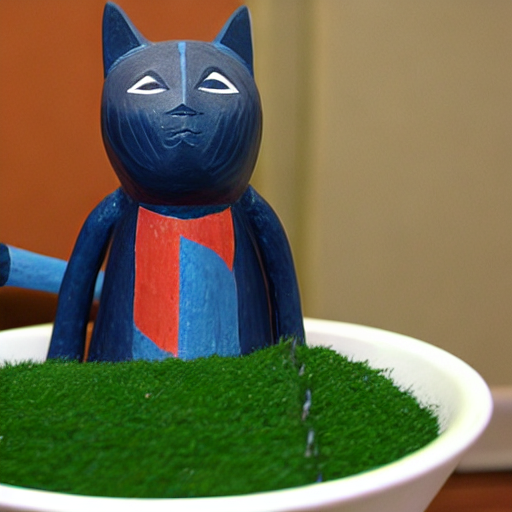

In [1]:
from IPython.display import Image
Image(filename='ouput.png')